<a href="https://colab.research.google.com/github/TheFoodForest/Plant-Pathology-Kaggle/blob/master/Colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


In [3]:
!git clone https://github.com/TheFoodForest/Plant-Pathology-Kaggle.git


Cloning into 'Plant-Pathology-Kaggle'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3651 (delta 0), reused 0 (delta 0), pack-reused 3648
Receiving objects: 100% (3651/3651), 832.85 MiB | 19.02 MiB/s, done.
Checking out files: 100% (3647/3647), done.


In [3]:
%cd "Plant-Pathology-Kaggle"

/content/drive/My Drive/Plant-Pathology-Kaggle


In [4]:
%ls

 augmented/                   images/     saved_model/   train.csv
'Disease Recognition.ipynb'   README.md   test.csv


In [11]:
%mkdir "augmented"

mkdir: cannot create directory ‘augmented’: File exists


In [8]:
%cd "augmented"

/content/drive/My Drive/Plant-Pathology-Kaggle/augmented


In [0]:
%mkdir "images"

In [10]:
%cd ../..

/content/drive/My Drive


In [13]:
%ls

 augmented/                   images/     saved_model/   train.csv
'Disease Recognition.ipynb'   README.md   test.csv


In [0]:
import pandas as pd
import numpy as np 
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import cv2
from tqdm import tqdm


import matplotlib.pyplot as plt


import os 
import glob

tqdm.pandas()

In [0]:
labels = pd.read_csv('train.csv')

In [7]:
display(labels.head())
labels.info()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [8]:

# image to array function 
def load_image(image_id):
    image = cv2.imread(image_id)
    image = cv2.resize(image, (256, 256))
    return np.float32(image)


def create_paths(img):
    return 'images/{}.jpg'.format(img)


labels['path'] = labels.image_id.progress_apply(create_paths)

100%|██████████| 1821/1821 [00:00<00:00, 318388.74it/s]


In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [10]:
X = labels.loc[:,'path']
y = labels.loc[:, labels.columns[1:5]]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=13,stratify=y,test_size=0.25)

# zippedtrain = zip(X_train,y_train)
# zippedtest = zip(X_test,y_test)
# train_df = pd.DataFrame({'path':X_train,'class':[list(i) for i in y_train]})
# test_df = pd.DataFrame({'path':X_test,'class':[list(i) for i in y_test]})

train_df = pd.DataFrame(X_train).join(pd.DataFrame(y_train))
test_df = pd.DataFrame(X_test).join(pd.DataFrame(y_test))

train_df.head()

,path,healthy,multiple_diseases,rust,scab
1601,images/Train_1601.jpg,1,0,0,0
1414,images/Train_1414.jpg,1,0,0,0
1701,images/Train_1701.jpg,0,0,0,1
516,images/Train_516.jpg,0,0,1,0
1708,images/Train_1708.jpg,0,1,0,0


In [11]:
fit_x = train_df.path.progress_apply(load_image).values

100%|██████████| 1365/1365 [00:46<00:00, 29.22it/s]


In [0]:

labels.drop(columns='image_id', inplace=True)
labels = labels[['path', 'healthy','multiple_diseases','rust','scab']]

In [13]:

labels.head()

,path,healthy,multiple_diseases,rust,scab
0,images/Train_0.jpg,0,0,0,1
1,images/Train_1.jpg,0,1,0,0
2,images/Train_2.jpg,1,0,0,0
3,images/Train_3.jpg,0,0,1,0
4,images/Train_4.jpg,1,0,0,0


In [14]:

fit_x = np.array([i for i in fit_x], dtype='float32')
fit_x.shape

(1365, 256, 256, 3)

In [0]:
class ChannelImageNormalization():
    def __init__(self, fulldataframe, train_dataframe, target_path, trainX):
        """
        @param dataframe: pandas dataframe with labels and image paths
        @param target_path: relative (or absolute) path to directory to store augmented images
        @param trainX: loaded training images (raw images, in cv2 default BGR order)
        """
        self.df = fulldataframe.copy() 
        self.target_path = target_path 
        self.train_dataframe = train_dataframe
        
        # getting first, second, third channel means of training data
        self.blue_mean = trainX[:,:,:,0].mean()
        self.green_mean = trainX[:,:,:,1].mean()
        self.red_mean = trainX[:,:,:,2].mean()
        
        #remove images in target path 
        files = glob.glob('{}/*'.format(target_path))
        for f in files:
            os.remove(f)
            
    def read_img(self, path, imgS):
        image = cv2.imread(path)
        image = cv2.resize(image, (imgS, imgS))
        return image
        
    def sub_mean_(self, image):
        image = image.astype('float64')
        image[:,:,0] -= self.blue_mean
        image[:,:,1] -= self.green_mean
        image[:,:,2] -= self.red_mean
        return image
    def increase_brightness_(self, img, value=30):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
        
    def save_image(self, image, counter):
        path = self.target_path + 'Train_' + str(counter) + '.png'
        cv2.imwrite(path, image)
        return path
        
    def run(self,imageS=256,bright_shift_range=50):
        self.counter = 0
        for index, row in self.df.iterrows():
            image = self.read_img(row[0], imageS)
            label = row[1::]
            if index in self.train_dataframe.index: 
                rand_shift = np.random.randint(high=bright_shift_range,low=0)
                image = self.increase_brightness_(image, value=rand_shift).astype('float64')
            image = self.sub_mean_(image)
            df_path = self.save_image(image, index)
            self.df.iloc[self.counter,0] = 'images/' + 'Train_' + str(index) + '.png'
            self.counter += 1
        return self.df 



norm = ChannelImageNormalization(labels, train_df, 'augmented/images/',fit_x)
new_labels = norm.run(imageS=512, bright_shift_range=75)

In [18]:
train_df

,path,healthy,multiple_diseases,rust,scab
1601,images/Train_1601.jpg,1,0,0,0
1414,images/Train_1414.jpg,1,0,0,0
1701,images/Train_1701.jpg,0,0,0,1
516,images/Train_516.jpg,0,0,1,0
1708,images/Train_1708.jpg,0,1,0,0
...,...,...,...,...,...
275,images/Train_275.jpg,0,0,1,0
1790,images/Train_1790.jpg,0,0,1,0
1322,images/Train_1322.jpg,0,0,1,0
1263,images/Train_1263.jpg,0,0,1,0


In [26]:

# X = new_labels.loc[:,'path']
# y = new_labels.loc[:, labels.columns[1:5]]

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y,test_size=0.3)

# # zippedtrain = zip(X_train,y_train)
# # zippedtest = zip(X_test,y_test)
# # train_df = pd.DataFrame({'path':X_train,'class':[list(i) for i in y_train]})
# # test_df = pd.DataFrame({'path':X_test,'class':[list(i) for i in y_test]})

# train_df = pd.DataFrame(X_train).join(pd.DataFrame(y_train))
# test_df = pd.DataFrame(X_test).join(pd.DataFrame(y_test))

# train_df.head()

,path,healthy,multiple_diseases,rust,scab
1800,images/Train_1800.png,0,0,0,1
1640,images/Train_1640.png,0,0,1,0
986,images/Train_986.png,0,0,0,1
17,images/Train_17.png,0,0,0,1
186,images/Train_186.png,0,0,0,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79.73324
130.7979
102.9642


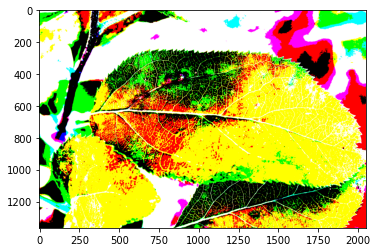

In [15]:
blue_mean = fit_x[:,:,:,0].mean() 
green_mean = fit_x[:,:,:,1].mean() 
red_mean = fit_x[:,:,:,2].mean() 
print(blue_mean)
print(green_mean)
print(red_mean)
def channel_norm(img):
    img = img.astype('float64')
    img[:,:,0] -= blue_mean
    img[:,:,1] -= green_mean
    img[:,:,2] -= red_mean
    return img
def random_blurr_channel_norm(img):
    img = img.astype('float64')
    img[:,:,0] -= blue_mean
    img[:,:,1] -= green_mean
    img[:,:,2] -= red_mean
    go = np.random.randint(0,10)
    if go == 7:
#         num = np.random.randint(10,30)
#         kernel = np.ones((num,num),'float')*( 1.0 / (num*num) )
#         img = cv2.filter2D(img,-1,kernel)
        num = np.random.randint(5,15)
        img = cv2.blur(img, (num,num))
    return img


img = random_blurr_channel_norm(cv2.imread(train_df.path[1800]))
plt.imshow(img)

In [16]:
batch = 64

imgH = 256
imgW = 256

image_generator_ = ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=0,
                                    height_shift_range=0, horizontal_flip=True, vertical_flip=True,zoom_range=0,
                                    featurewise_center=True)
val_image_gen_ = ImageDataGenerator(rescale=1./255, featurewise_center=True)
image_generator_.mean = [blue_mean/255, green_mean/255, red_mean/255]
val_image_gen_.mean = [blue_mean/255, green_mean/255, red_mean/255]

valGen_ = val_image_gen_.flow_from_dataframe(test_df,directory=None, x_col='path',
                                           y_col=['healthy','multiple_diseases','rust','scab'],
                                          batch_size=batch, class_mode='raw', target_size=(imgH,imgW))

traindataGen_ = image_generator_.flow_from_dataframe(train_df, directory=None, x_col='path', 
                                                   y_col=['healthy','multiple_diseases','rust','scab'],
                                                  target_size=(imgH,imgW), batch_size=batch, class_mode='raw')

Found 456 validated image filenames.
Found 1365 validated image filenames.


[1 0 0 0]
[[[-0.16477151 -0.29051527 -0.25587332]
  [-0.16365975 -0.27708912 -0.24552578]
  [-0.16365975 -0.26114938 -0.23796973]
  ...
  [ 0.30820647  0.20444992  0.1444013 ]
  [ 0.28735676  0.18562815  0.13937418]
  [ 0.27113363  0.17143288  0.13126259]]

 [[-0.17288306 -0.2986268  -0.2639849 ]
  [-0.16365975 -0.28520066 -0.2516094 ]
  [-0.16365975 -0.2712888  -0.2420255 ]
  ...
  [ 0.27672753  0.1763275   0.13405947]
  [ 0.2605044   0.16213235  0.125948  ]
  [ 0.250127    0.15378276  0.12952767]]

 [[-0.17975818 -0.30797482 -0.26962355]
  [-0.16756845 -0.29331222 -0.25867027]
  [-0.16365975 -0.27988604 -0.24762349]
  ...
  [ 0.25362316  0.1565797   0.12812923]
  [ 0.24348365  0.1484681   0.13218503]
  [ 0.24994652  0.15419176  0.14454184]]

 ...

 [[ 0.03369246 -0.0136199   0.02494361]
  [ 0.03572036 -0.01159201  0.02697148]
  [ 0.03915624 -0.0081561   0.03040739]
  ...
  [ 0.06517477 -0.01512269 -0.05521954]
  [ 0.0697103  -0.00505302 -0.04099936]
  [ 0.07414795  0.00501659 -0.0323

<Figure size 576x576 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


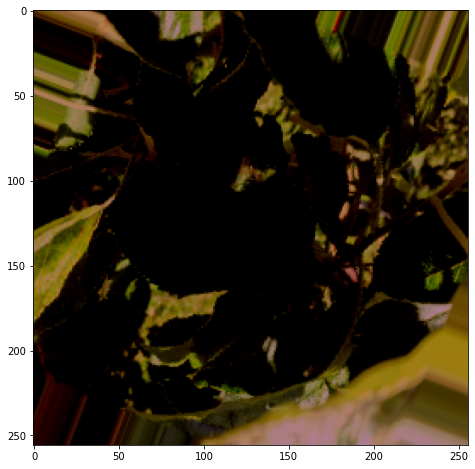

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 0 0 0]


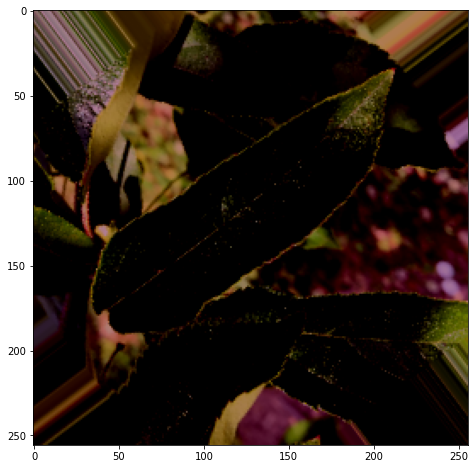

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1 0 0]


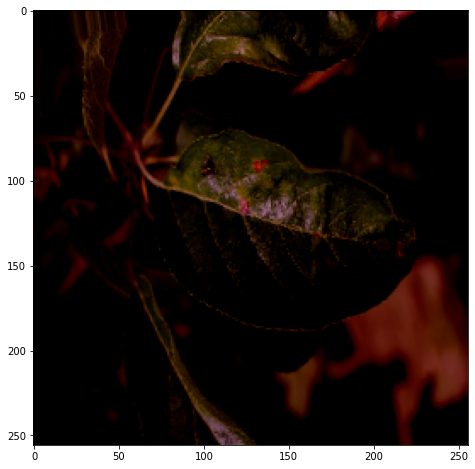

[1 0 0 0]
[[[ 0.13830106  0.04799434 -0.16347787]
  [ 0.1348928   0.03381452 -0.1735447 ]
  [ 0.11438878  0.02001759 -0.18063463]
  ...
  [-0.10200226 -0.29738963 -0.26166004]
  [-0.09697159 -0.29068202 -0.25998315]
  [-0.09118716 -0.2835976  -0.25792938]]

 [[ 0.14196227  0.05104074 -0.16137616]
  [ 0.13830106  0.04052212 -0.16908208]
  [ 0.12368442  0.02634224 -0.17728083]
  ...
  [-0.09023131 -0.28264174 -0.25754705]
  [-0.08184685 -0.27425727 -0.25419328]
  [-0.07346264 -0.2658728  -0.25083947]]

 [[ 0.15034674  0.04936382 -0.16305307]
  [ 0.13830106  0.04722967 -0.16405138]
  [ 0.13374577  0.03304985 -0.17392705]
  ...
  [-0.07269794 -0.26491693 -0.25045714]
  [-0.06599037 -0.2565325  -0.24710335]
  [-0.05928279 -0.24814802 -0.24374957]]

 ...

 [[-0.04332168 -0.23261222 -0.25003833]
  [-0.05359547 -0.238895   -0.25622606]
  [-0.06197993 -0.24895635 -0.25957984]
  ...
  [-0.19314301 -0.34633774 -0.33130366]
  [-0.19763261 -0.34562674 -0.32799232]
  [-0.19673017 -0.35764766 -0.3231

<Figure size 576x576 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 1 0]


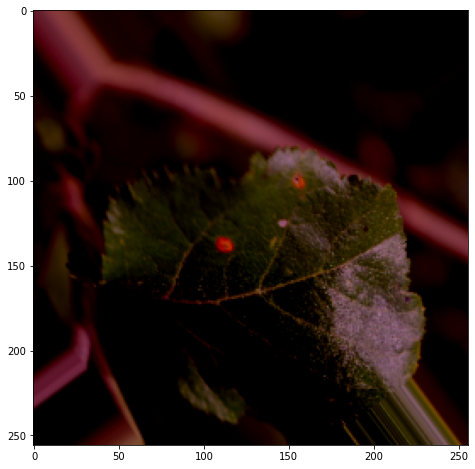

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 1 0]


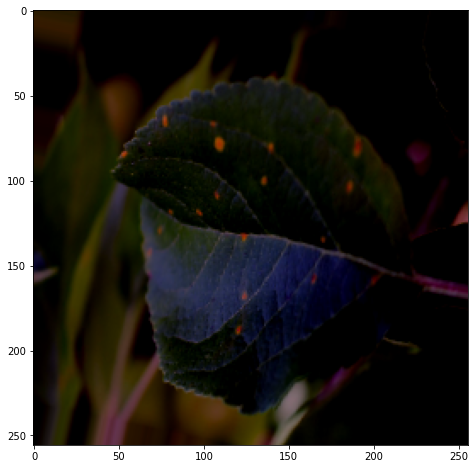

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


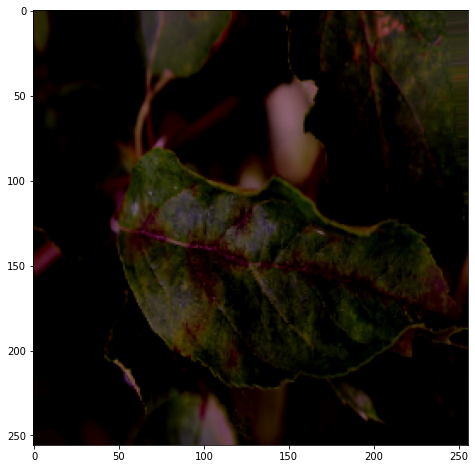

In [17]:
counter = 0
for x, label in traindataGen_:
    
    if counter == 2:
        break
    print(label[1])
    print
    plt.figure(figsize=(8,8))
    print(x[1])
    plt.show()
    print(label[2])
    plt.figure(figsize=(8,8))
    plt.imshow(x[2])
    plt.show()
    print(label[3])
    plt.figure(figsize=(8,8))
    plt.imshow(x[3])
    plt.show()
    print(label[4])
    plt.figure(figsize=(8,8))
    plt.imshow(x[4])
    plt.show()
    counter += 1


In [18]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(imgH, imgW,3), padding='valid',
                       data_format='channels_last'))
model2.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))


model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(y_train.shape[1], activation='softmax'))

model2.summary()





STEP_SIZE_TRAIN=traindataGen_.n//traindataGen_.batch_size
STEP_SIZE_VALID=valGen_.n//valGen_.batch_size


epochs = 50
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

history2 = model2.fit(traindataGen_, 
                              epochs=epochs,
                   validation_data=valGen_,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0

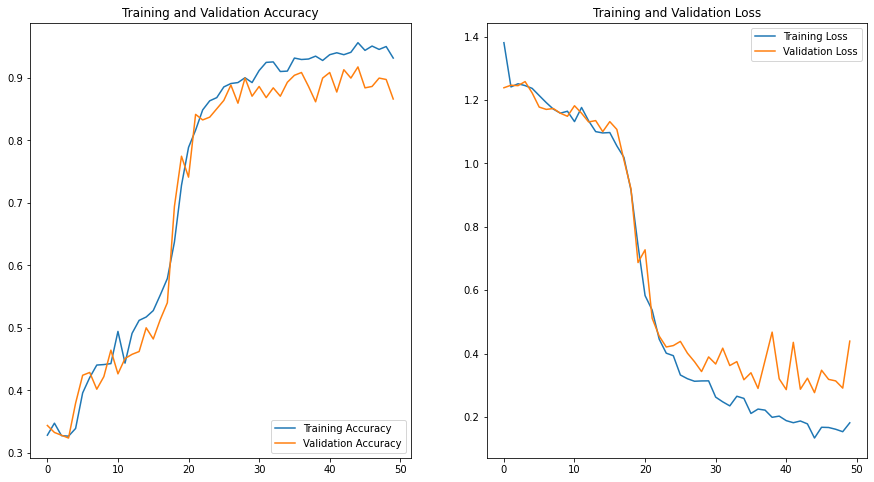

In [19]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
label_array = labels.columns[1::]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


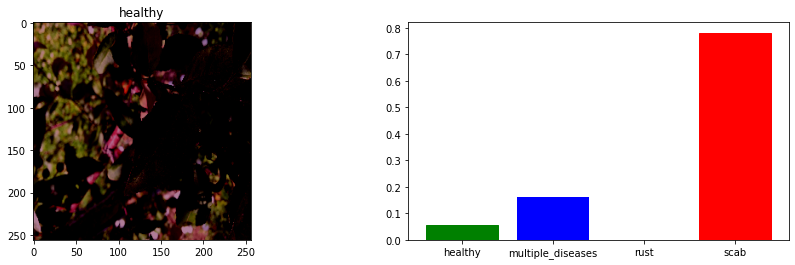

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


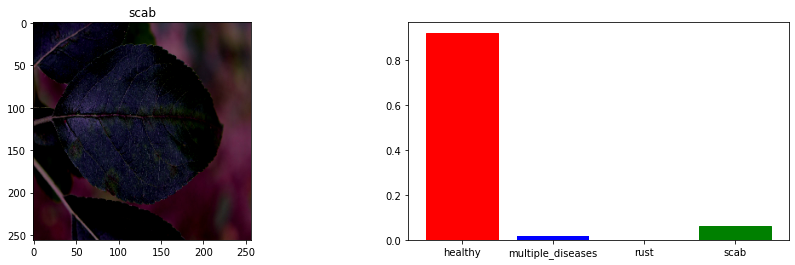

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


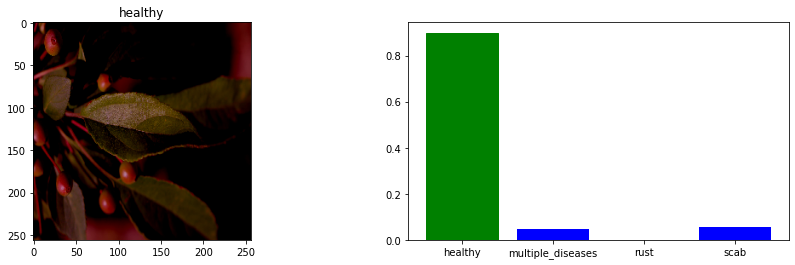

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


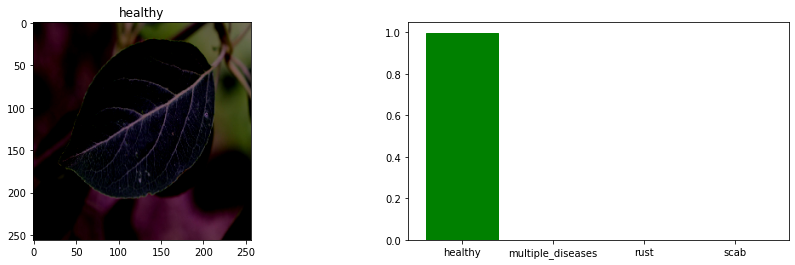

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


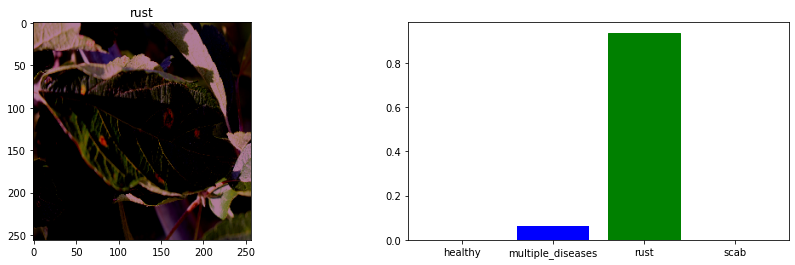

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


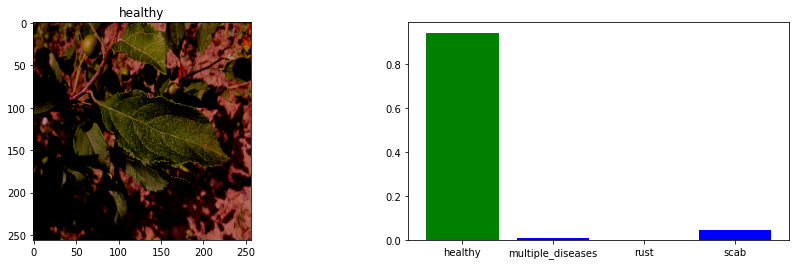

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


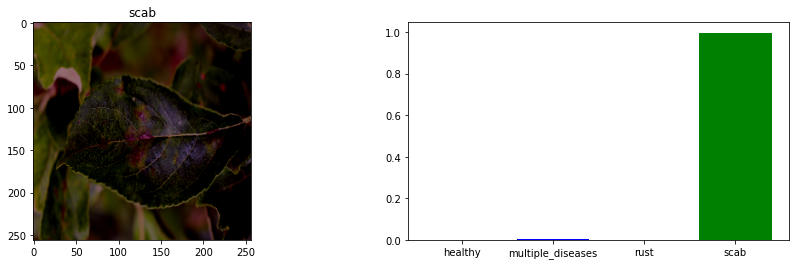

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


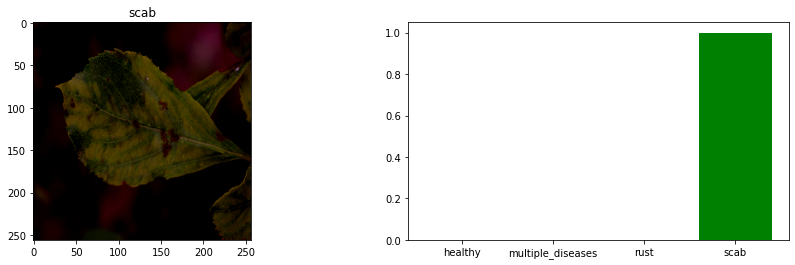

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


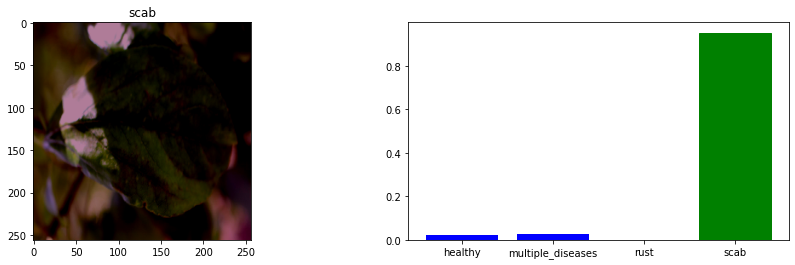

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


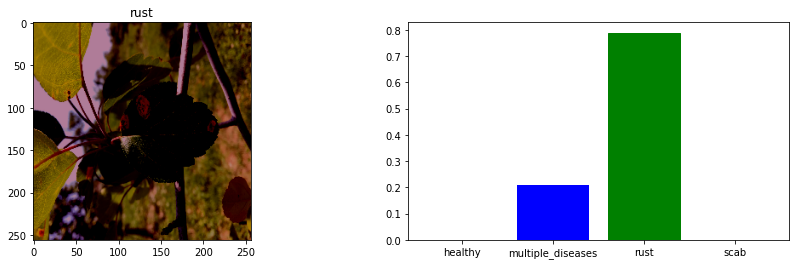

In [38]:

# plot_imgs = val_images.copy()
tru_labels = y_test.values
counter = 0
for i, label in valGen_:
    if counter <= 9:
        # index = np.random.randint(low=0, high=len(plot_imgs), size=1)
        # img_predicted_on = plot_imgs[index][0]
        # full_img_path = test_df.path.values[index]
        # full_img_path = full_img_path[0].split('.')[0] + '.jpg'
        # img = cv2.imread(full_img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pred_array = model2.predict(i)
        pred_class = label_array[np.argmax(pred_array[0])]
        
        tru_class = label_array[np.argmax(label)]
    #     if tru_class in ['healthy','rust']:
    #         continue
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        if pred_class == tru_class:
            pred_color = 'g'
            tru_color = 'g'
        else:
            pred_color = 'r'
            tru_color = 'g'
            
        ax[0].imshow(i[0])
        ax[0].set_title('{}'.format(tru_class))
        bar = ax[1].bar(label_array, pred_array[0], color='b')
        bar[np.argmax(pred_array[0])].set_color(pred_color)
        bar[np.argmax(label)].set_color(tru_color)
        counter += 1
        plt.show()
    else:
      break

# counter = 0
# for i, label in valGen_:
#   if counter <= 9:
#     print(i[0].shape)
#     counter +=1 
#   else:
#     break

In [0]:
import seaborn as sns
confustion = tf.math.confusion_matrix(tru_labels, predictions, num_classes=4)
plt.figure(figsize=(15,15))
sns.heatmap(confusion, annot=True)

In [39]:
model2.save('saved_model/model2_colab')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model2_colab/assets


In [40]:
%ls


 augmented/                   images/     saved_model/   train.csv
'Disease Recognition.ipynb'   README.md   test.csv
